# Binary Sentiment Analysis on IMDB Reviews Dataset

# Libraries & Modules

In [1]:
# Manage Warnings
import warnings
warnings.filterwarnings("ignore")

# Libraris & Modules
import os
import sys
import shutil
import re as regex
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation

# TensorFlow Log Level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# TensorFlow Libraries
import tensorflow as tf

# Environment/Versions
print("Python Env : ", sys.version)
print("TensorFlow : ", tf.__version__)

# Random Generator Seed
random_seed = 47

Python Env :  3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
TensorFlow :  2.12.0


# Downloading & Exploring Dataset

In [2]:
# Dataset Download Path
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Retrieve File (and untar)
dataset = tf.keras.utils.get_file(fname="aclImdb_v1", 
                                  origin=url, 
                                  untar=True, 
                                  cache_dir=".", 
                                  cache_subdir="")

# Dataset Directory
dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

84125825/84125825 [==============================] - 8s 0us/step


In [3]:
# List Dataset Sub-Directories & Files
display(os.listdir(dataset_dir))

['imdb.vocab', 'README', 'imdbEr.txt', 'train', 'test']

In [4]:
# Review Readme File
with open(os.path.join(dataset_dir, 'README'), 'r') as f:
    print(f.read())

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [5]:
# Train & Test Directories
display(os.listdir(f"{dataset_dir}/train"))
display(os.listdir(f"{dataset_dir}/test"))

['neg',
 'pos',
 'urls_pos.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_unsup.txt',
 'labeledBow.feat',
 'unsup']

['neg', 'pos', 'urls_pos.txt', 'urls_neg.txt', 'labeledBow.feat']

In [6]:
# Training Data Directory
train_dir = os.path.join(dataset_dir, "train")
train_dir_items = os.listdir(train_dir)
train_dir_items

['neg',
 'pos',
 'urls_pos.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_unsup.txt',
 'labeledBow.feat',
 'unsup']

In [7]:
# Testing Data Directory
test_dir = os.path.join(dataset_dir, "test")
os.listdir(test_dir)

['neg', 'pos', 'urls_pos.txt', 'urls_neg.txt', 'labeledBow.feat']

In [8]:
# View a sample positive review.
train_files = os.listdir(os.path.join(train_dir, "pos"))
sample_fname = train_files[2]
print(f"File : {sample_fname}\n")
with open(os.path.join(train_dir, f"pos/{sample_fname}")) as f:
    print(f.read())

File : 9318_9.txt

Red Skelton was still another major star who made the transition from movies to television with ease.<br /><br />His shows certainly brought a laughter to the American households of years back.<br /><br />He would begin the show with an opening monologue. Afterwards, we would have a variety of characters. Remember Gertrude and Heathcliff in the monologue? How can we ever forget San Fernando Red? I remember one episode where as a king Red introduced his queen by referring to her as your fatness.<br /><br />Go know that Red would use his comedic talents to really hide from his tragic life. He lost a son to leukemia at age 11 or so. His wife, Georgia, died by suicide.


In [9]:
tf.keras.utils.text_dataset_from_directory?

In [10]:
# Prepare Training Directory as per 'text_dataset_from_directory' Requirements.
# -----------------------------------------------------------------------------
# Create New Directory for Unsupervised Data
train_unsup_dir = os.path.join(dataset_dir, "train_unsup")
if not os.path.exists(train_unsup_dir):
    os.makedirs(train_unsup_dir)
else:
    pass
display(os.listdir(dataset_dir))
# Collect Unsupervised Data Files and Directories
file_list = [_ for _ in train_dir_items if "unsup" in _]
# Source & Destination Directories
source_dir = train_dir
destination_dir = train_unsup_dir
# Move Files and Directories
for file in file_list:
    source_file = os.path.join(source_dir, file)
    destination_file = os.path.join(destination_dir, file)
    # Move as per Directory/File
    if os.path.isdir(source_file):
        shutil.copytree(source_file, destination_file)
        shutil.rmtree(source_file)
    else:
        shutil.move(source_file, destination_file)

# Review Training & Unsupervised Training Data Directories
display(os.listdir(train_dir))
display(os.listdir(train_unsup_dir))

['imdb.vocab', 'train_unsup', 'README', 'imdbEr.txt', 'train', 'test']

['neg', 'pos', 'urls_pos.txt', 'urls_neg.txt', 'labeledBow.feat']

['unsupBow.feat', 'urls_unsup.txt', 'unsup']

# Training, Validation & Testing Datasets

In [11]:
# Training Dataset
print("Training Dataset :")
train_ds = tf.keras.utils.text_dataset_from_directory(directory=train_dir, 
                                                      batch_size=8, 
                                                      validation_split=0.2, 
                                                      subset='training', 
                                                      seed=random_seed)

# Validation Dataset
print("\n")
print("Validation Dataset :")
val_ds = tf.keras.utils.text_dataset_from_directory(directory=train_dir, 
                                                    batch_size=8, 
                                                    validation_split=0.2, 
                                                    subset='validation', 
                                                    seed=random_seed)

# Testing Dataset
print("\n")
print("Testing Dataset :")
test_ds = tf.keras.utils.text_dataset_from_directory(directory=test_dir, 
                                                     batch_size=8)

Training Dataset :
Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Validation Dataset :
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Testing Dataset :
Found 25000 files belonging to 2 classes.


In [12]:
# Review Dataset
for x, y in train_ds.take(1):
    print(f"Dataset Element 1 (Labels)  : {tf.shape(y)}")
    print(f"Dataset Element 1 (Reviews) : {tf.shape(x)}\n")
    for i in range(5):
        tf.print(f"LABEL  : {y[i]}")
        tf.print(f"REVIEW : {x[i]}")
        tf.print("-"*80)

Dataset Element 1 (Labels)  : [8]
Dataset Element 1 (Reviews) : [8]

LABEL  : 0
REVIEW : b"I wouldn't say this is a *bad* movie. Unfortunately for me, I get the feeling that the more you know about fencing, the worse it gets simply due to the fact that it becomes totally unrealistic. I've been fencing since i was 14 years old, and this movie portrays it very poorly. F. Murray Abraham is good (and appears to have some fencing background), but most of the other actors--especially the students--just seem to be lost."
--------------------------------------------------------------------------------
LABEL  : 1
REVIEW : b'Family problems abound in real life and that is what this movie is about. Love can hold the members together through out the ordeals and trials and that is what this movie is about. One man, Daddy, has the maturity and fortitude to sustain the family in the face of adversity. The kids grow up,one all be it, in the hard way, to realize that no matter how old they or a parent 

In [13]:
# Class Names Corresponding to Index (as Numerical Label)
display(train_ds.class_names)

['neg', 'pos']

# Data Preparation

## Custom Standardization Function

Removing Punctuations & HTML Elements.

In [14]:
# Function Definition : Remove HTML Tags & Punctuations
def custom_standardize(input_data):
    """Remove HTML Tags & Punctuations"""
    
    # Convert to Lowercase
    lowercase = tf.strings.lower(input_data)
    
    # Remove the '<br />' Tag
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    
    # Remove Punctuations
    stripped_html_punc = tf.strings.regex_replace(stripped_html,
        "[%s]" % regex.escape(punctuation), ""
    )
    
    return stripped_html_punc

## Tokenization & Vectorization

- Custom function for Standardization
- Splitting strings into tokens. --> tf.keras.layers.TextVectorization()
- Converting tokens into numbers for neural network.

In [15]:
# Calculate Maximum Features Value
# --------------------------------
# Collect all Word Tokens provided in Dataset
vocab_tokens = list()
with open(os.path.join(dataset_dir, "imdb.vocab"), "r") as f:
    for line in f:
        vocab_tokens.append(line.strip())
vocab_tokens = set(vocab_tokens)       

# Calc. Max. Features rounded to next hundred
max_features = round(len(vocab_tokens)+100, -2)

# Delete Token Object
del vocab_tokens

# Display Max. Features
print("Maximum Features(Tokens) in Entire Dataset : ", max_features)

# Set Maximum Sequence Length
# ---------------------------
max_seq_len = 250
print("Maximum Output Sequence Length of Vectorization Layer : ", max_seq_len)

Maximum Features(Tokens) in Entire Dataset :  89600
Maximum Output Sequence Length of Vectorization Layer :  250


In [16]:
# Vectorization Layer
T_Vect = tf.keras.layers.TextVectorization(standardize=custom_standardize, 
                                           max_tokens=max_features, 
                                           output_mode="int", 
                                           output_sequence_length=max_seq_len)
display(T_Vect)

In [17]:
# Fit State of Preprocessing Layer to the Dataset
training_text = train_ds.map(lambda x, _ : x)
T_Vect.adapt(training_text)
display(T_Vect)

In [18]:
# Review Vectorization Layer's Output
for x, y in train_ds.take(1):
    print(f"Dataset Element 1 (Labels)  : {tf.shape(y)}")
    print(f"Dataset Element 1 (Reviews) : {tf.shape(x)}\n")
    for i in range(1):
        tf.print(f"LABEL  : {y[i]}")
        tf.print(f"REVIEW : {x[i]}")
        tf.print("-"*80)
        tf.print(f"VECTORIZED REVIEW :")
        vectorized = T_Vect(tf.expand_dims(x[i], -1))
        print(vectorized)
        tf.print("-"*80)
        print("First Token : ", vectorized[0][0])
        print("Corresponding Vocabulary : ", T_Vect.get_vocabulary()[vectorized[0][0]])
        print("Vocabulary Size : ", len(T_Vect.get_vocabulary()))

Dataset Element 1 (Labels)  : [8]
Dataset Element 1 (Reviews) : [8]

LABEL  : 0
REVIEW : b"This film turned up on local TV here in South Africa recently and I thought that I'd warn even those who enjoy watching B grade bad movies (which I do)that this is not even amusing. The plot concerns a couple visiting a house in the country. Some strangers appear and .... The problem is that most of the film, obviously shot in the early seventies, consists of extreme wide shots of people walking, in real time and awfully slowly, from A to B. This makes the film tedious in the extreme and the expected blood and gore payoff just never happens. I am really curious - how many people have actually watched this from beginning to end?"
--------------------------------------------------------------------------------
VECTORIZED REVIEW :
tf.Tensor(
[[   11    19   695    54    20   686   246   128     8  1207  2334   998
      3    10   197    12   441  2792    53   143    35   350   146   959
   1467    7

# Finalizing Datasets

In [19]:
# Function to Map Vectorization to Dataset
def vectorize(reviews, labels):
    return T_Vect(tf.expand_dims(reviews, -1)), labels

In [20]:
# Prepare Training, Testing and Validation Datasets
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).map(vectorize)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).map(vectorize)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).map(vectorize)

# Model Building

In [21]:
# Token Embedding Depth
embedding_dim = 24

# Define Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features + 1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)],
    name="Sequential_Text_Classification"
)

# Compile Model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model.summary()

Model: "Sequential_Text_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 24)          2150424   
                                                                 
 dropout (Dropout)           (None, None, 24)          0         
                                                                 
 global_average_pooling1d (G  (None, 24)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2,150,449
Trainable params: 2,150,449
Non-trainable params: 0
__________________________

# Training

In [22]:
hist = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
2500/2500 [==============================] - 47s 18ms/step - loss: 0.5635 - binary_accuracy: 0.7685 - val_loss: 0.4282 - val_binary_accuracy: 0.8364
Epoch 2/5
2500/2500 [==============================] - 46s 18ms/step - loss: 0.3390 - binary_accuracy: 0.8767 - val_loss: 0.3309 - val_binary_accuracy: 0.8634
Epoch 3/5
2500/2500 [==============================] - 46s 19ms/step - loss: 0.2500 - binary_accuracy: 0.9104 - val_loss: 0.3016 - val_binary_accuracy: 0.8782
Epoch 4/5
2500/2500 [==============================] - 47s 19ms/step - loss: 0.1969 - binary_accuracy: 0.9313 - val_loss: 0.2927 - val_binary_accuracy: 0.8802
Epoch 5/5
2500/2500 [==============================] - 47s 19ms/step - loss: 0.1584 - binary_accuracy: 0.9463 - val_loss: 0.2939 - val_binary_accuracy: 0.8798


# Evaluation

In [23]:
loss, accuracy = model.evaluate(test_ds)
print(f"Loss     : {round(loss, 2)}")
print(f"Accuracy : {round(accuracy*100, 2)} %")

3125/3125 [==============================] - 5s 2ms/step - loss: 0.3100 - binary_accuracy: 0.8738
Loss     : 0.31
Accuracy : 87.38 %


# Training Metrics

In [24]:
history_dict = hist.history
display(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

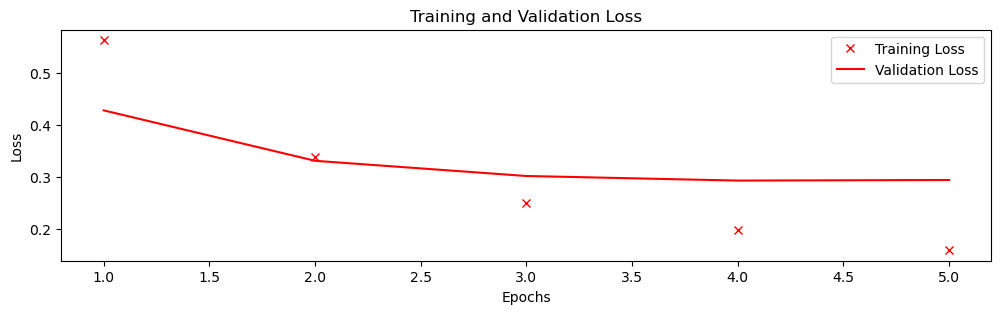

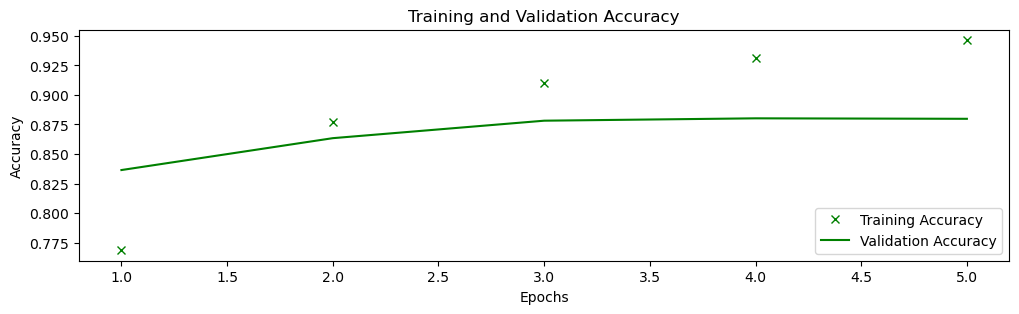

In [25]:
# Define Visualization Data
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Define Epochs Range
epochs = range(1, len(acc) + 1)

# Plot Losses
plt.figure(figsize=(12,3))
plt.plot(epochs, loss, 'rx', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracies
plt.figure(figsize=(12,3))
plt.plot(epochs, acc, 'gx', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Exporting Model

In [26]:
# Define Model for Exporting
export_model = tf.keras.Sequential([
    T_Vect,
    model,
    tf.keras.layers.Activation("sigmoid")
])

# Compile Model
export_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                     optimizer="adam", 
                     metrics=['accuracy'])

# Original Raw Test Data
test_raw = tf.keras.utils.text_dataset_from_directory(directory=test_dir, 
                                                      batch_size=8)
# Test Accuracy on Test Data
loss, accuracy = export_model.evaluate(test_raw)
print(f"Loss     : {round(loss, 2)}")
print(f"Accuracy : {round(accuracy*100, 2)} %")

Found 25000 files belonging to 2 classes.
3125/3125 [==============================] - 8s 3ms/step - loss: 0.3100 - accuracy: 0.8738
Loss     : 0.31
Accuracy : 87.38 %


In [27]:
# Export Model to Directory
tf.keras.saving.save_model(model=export_model, 
                           filepath="saved_models", 
                           overwrite=True, 
                           save_format="tf")

# Inference of Exported Model on Fresh Data

In [28]:
# Example Fresh Data
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible...",
    "I thought the movie was enlightening, but my friend thought it as misleading.",
    "I thought the movie was misleading, but my friend thought it as okay."
]

# Raw Predictions
preds = export_model.predict(examples)
print("-"*36)
print("Raw Predictions:")
print("-"*36)
display(preds)

# Predictions as Labels
print("-"*36)
print("Predictions as Labels:")
print("-"*36)
pred_labels = np.where(preds > 0.5, 1, 0)
display(pred_labels)

1/1 [==============================] - 0s 167ms/step
------------------------------------
Raw Predictions:
------------------------------------


array([[0.70621717],
       [0.5005356 ],
       [0.36248305],
       [0.657733  ],
       [0.59446037]], dtype=float32)

------------------------------------
Predictions as Labels:
------------------------------------


array([[1],
       [1],
       [0],
       [1],
       [1]])